In [1]:
import os

import matplotlib.pyplot as plt
import seisbench.models as sbm
import torch
from evaluation.noisy_dataset_evaluation import find_large_error_traces, eval_mse
from utils.common import load_dataset_and_labels, load_pretrained_model, assert_path_exists, sublist_compement

# Model Evaluation

## Introduction

The purpose of this notebook is to examine the traces for which the model performed worse. In particular, consider the 10dB dataset generated using ETHZ and Joachim Noises and look at the traces where the pretrained model performed worse than a second away.

## Requirements and Configuration

In [2]:
# Possible values
DATASETS_ORIGINS = ['ethz', 'geofon']
SBM_CLASSES= [sbm.PhaseNet, sbm.EQTransformer]
MODEL_TO_NUM_SAMPLES = {sbm.EQTransformer:6000, sbm.PhaseNet: 3001}

In [3]:
dataset_origin = 'ethz'
assert dataset_origin in DATASETS_ORIGINS, f'Expected dataset one of {DATASETS_ORIGINS}. Got {dataset_origin}.'

In [4]:
SBM_CLASS= sbm.PhaseNet
assert SBM_CLASS in SBM_CLASSES
SBM_CLASS

seisbench.models.phasenet.PhaseNet

In [5]:
NUM_SAMPLES=MODEL_TO_NUM_SAMPLES[SBM_CLASS]
NUM_SAMPLES       # Trace sample length - If the dataset is built for phasenet: 3001 If it is for EQTransformer: 6000

3001

In [6]:
SAMPLE_RATE=100                   # Sampling Rate - PhaseNet and EQTransformer expect 100Hz
LARGE_ERROR_THRESHOLD_SECONDS=1   # Onset prediction above this value (seconds) shall be considered large for metrics
# The following value is the threshold in sample
LARGE_ERROR_THRESHOLD_SAMPLES=LARGE_ERROR_THRESHOLD_SECONDS*SAMPLE_RATE
SYNTHESIZED_SNR_LIST=list(range(2,11))                # SNR levels of the synthetic data used`
NUM_OF_ORIGINAL_TRACES = 1200       # How many original traces to use for the noisy dataset - use slice from the start

Browse The path of the dataset the model is going to be evaluated on.
The original data and synthetic noised data.

In [7]:
DATASET_PATH=f'/home/moshe/datasets/GFZ/noisy_datasets/{dataset_origin}_{NUM_SAMPLES}_sample_joachim_noises_energy_ratio_snr/'
NOISY_DATA_PATH_LIST = [os.path.join(DATASET_PATH, f'noisy_dataset_snr_{synthesized_snr}') for synthesized_snr in SYNTHESIZED_SNR_LIST ]
DATASET_PATH, NOISY_DATA_PATH_LIST

('/home/moshe/datasets/GFZ/noisy_datasets/ethz_3001_sample_joachim_noises_energy_ratio_snr/',
 ['/home/moshe/datasets/GFZ/noisy_datasets/ethz_3001_sample_joachim_noises_energy_ratio_snr/noisy_dataset_snr_2',
  '/home/moshe/datasets/GFZ/noisy_datasets/ethz_3001_sample_joachim_noises_energy_ratio_snr/noisy_dataset_snr_3',
  '/home/moshe/datasets/GFZ/noisy_datasets/ethz_3001_sample_joachim_noises_energy_ratio_snr/noisy_dataset_snr_4',
  '/home/moshe/datasets/GFZ/noisy_datasets/ethz_3001_sample_joachim_noises_energy_ratio_snr/noisy_dataset_snr_5',
  '/home/moshe/datasets/GFZ/noisy_datasets/ethz_3001_sample_joachim_noises_energy_ratio_snr/noisy_dataset_snr_6',
  '/home/moshe/datasets/GFZ/noisy_datasets/ethz_3001_sample_joachim_noises_energy_ratio_snr/noisy_dataset_snr_7',
  '/home/moshe/datasets/GFZ/noisy_datasets/ethz_3001_sample_joachim_noises_energy_ratio_snr/noisy_dataset_snr_8',
  '/home/moshe/datasets/GFZ/noisy_datasets/ethz_3001_sample_joachim_noises_energy_ratio_snr/noisy_dataset_sn

In [8]:
assert_path_exists(path_str=DATASET_PATH, name='DATASET_PATH')
for ndp in NOISY_DATA_PATH_LIST:
    assert_path_exists(path_str=ndp, name='NOISY_DATA_PATH')

## Choose Indices To Use

In [9]:
total_indicies_not_to_use = []
snr_indices_used = []
for ndp in NOISY_DATA_PATH_LIST:
    snr_indices_not_used = torch.load(os.path.join(ndp, 'indices_not_used')).tolist()
    total_indicies_not_to_use.extend(snr_indices_not_used)
    snr_indices_used.append(sublist_compement(containing_list=list(range(NUM_OF_ORIGINAL_TRACES)), sublist=snr_indices_not_used))
total_indicies_not_to_use = list(set(total_indicies_not_to_use))
len(total_indicies_not_to_use)

135

## Remove The not To Use Traces

In [10]:
def remove_traces_not_to_use(noisy_traces_list, noisy_labels_list):
    clean_noisy_traces_list=[]
    clean_noisy_labels_list=[]
    for i,ndp in enumerate(NOISY_DATA_PATH_LIST):
        snr_total_indicies_not_to_use = [k for k,l in enumerate(snr_indices_used[i]) if l in total_indicies_not_to_use]
        snr_total_indicies_to_use = sublist_compement(containing_list=list(range(len(snr_indices_used[i]))), sublist=snr_total_indicies_not_to_use)
        clean_noisy_traces_list.append(noisy_traces_list[i][snr_total_indicies_to_use])
        clean_noisy_labels_list.append(noisy_labels_list[i][snr_total_indicies_to_use])
    return clean_noisy_traces_list, clean_noisy_labels_list

In [11]:
total_indicies_to_use = sublist_compement(containing_list=list(range(NUM_OF_ORIGINAL_TRACES)), sublist=total_indicies_not_to_use)
    # [i for i in range(NUM_OF_ORIGINAL_TRACES) if i not in indicies_not_to_use]
len(total_indicies_to_use)

1118

### Load the original High SNR Traces

Load a dataset of high SNR traces taken from the original ETHZ\GEOFON dataset.

In [12]:
dataset_traces_path = os.path.join(DATASET_PATH, 'original_dataset.pt')
dataset_labels_path = os.path.join(DATASET_PATH, 'original_labels.pt')
original_dataset = torch.load(dataset_traces_path)[total_indicies_to_use]  #[:num_traces]
original_labels = torch.load(dataset_labels_path)[total_indicies_to_use]    #[:num_traces]

num_original_traces = original_dataset.shape[0]
num_original_labels = original_labels.shape[0]
num_original_samples = original_dataset.shape[-1]

assert num_original_labels == num_original_traces, f'Expected traces equal num labels.Got {num_original_traces} traces and {num_original_labels} labels'
assert num_original_samples == NUM_SAMPLES, f'Expected {NUM_SAMPLES} in each trace. Got {num_original_samples}.'

print(f'Loaded {num_original_traces} traces and corresponding labels.')

Loaded 1118 traces and corresponding labels.


### Load the Synthetic Noisy Traces

In [13]:
synthetic_noisy_dataset_paths= [os.path.join(ndp, 'traces.pt') for ndp in NOISY_DATA_PATH_LIST]

synthetic_noisy_labels_paths= [os.path.join(ndp, 'labels.pt') for ndp in NOISY_DATA_PATH_LIST]

augmented_noises_paths = [os.path.join(ndp, 'full_noise_traces.pt') for ndp in NOISY_DATA_PATH_LIST]

factors_paths = [os.path.join(ndp, 'factors.pt') for ndp in NOISY_DATA_PATH_LIST]

In [14]:
for synthetic_noisy_dataset_path, synthetic_noisy_labels_path, augmented_noises_path, factors_path in zip(synthetic_noisy_dataset_paths, synthetic_noisy_labels_paths,augmented_noises_paths, factors_paths):
    assert_path_exists(path_str=synthetic_noisy_dataset_path, name='synthetic_noisy_dataset_path')
    assert_path_exists(path_str=synthetic_noisy_labels_path, name='synthetic_noisy_labels_path')
    assert_path_exists(path_str=augmented_noises_path, name='augmented_noises_path')
    assert_path_exists(path_str=factors_path, name='factors_path')

In [15]:
noisy_traces_list, noisy_traces_labels_list = [], []
for synthetic_noisy_dataset_path, synthetic_noisy_labels_path in zip(synthetic_noisy_dataset_paths, synthetic_noisy_labels_paths):
    synthetic_noisy_dataset, synthetic_noisy_labels = load_dataset_and_labels(dataset_path=synthetic_noisy_dataset_path, labels_path=synthetic_noisy_labels_path)
    synthetic_noisy_dataset, synthetic_noisy_labels = synthetic_noisy_dataset.float(), synthetic_noisy_labels.float()

    assert NUM_SAMPLES == synthetic_noisy_dataset.shape[-1], f'Expected Dataset contain {NUM_SAMPLES} samples. Got {synthetic_noisy_dataset.shape[-1]}'
    assert synthetic_noisy_dataset.shape[0] == synthetic_noisy_labels.shape[0], f'Expected Dataset contain label for each trace. Got {synthetic_noisy_dataset.shape[0]} traces and {synthetic_noisy_labels.shape[0]} labels'

    print(f'The loaded dataset has {synthetic_noisy_dataset.shape[0]} traces')
    print(f'Each has {synthetic_noisy_dataset.shape[1]} channels of {synthetic_noisy_dataset.shape[2]} samples.')
    print(f'Each entry is of type {synthetic_noisy_dataset.dtype}')

    print(f'The loaded labels have {synthetic_noisy_labels.shape[0]} labels.')
    print(f'Each entry is of type {synthetic_noisy_labels.dtype}')

    noisy_traces_list.append(synthetic_noisy_dataset)
    noisy_traces_labels_list.append(synthetic_noisy_labels)

The loaded dataset has 1924 traces
Each has 3 channels of 3001 samples.
Each entry is of type torch.float32
The loaded labels have 1924 labels.
Each entry is of type torch.float32
The loaded dataset has 1970 traces
Each has 3 channels of 3001 samples.
Each entry is of type torch.float32
The loaded labels have 1970 labels.
Each entry is of type torch.float32
The loaded dataset has 1982 traces
Each has 3 channels of 3001 samples.
Each entry is of type torch.float32
The loaded labels have 1982 labels.
Each entry is of type torch.float32
The loaded dataset has 1993 traces
Each has 3 channels of 3001 samples.
Each entry is of type torch.float32
The loaded labels have 1993 labels.
Each entry is of type torch.float32
The loaded dataset has 1994 traces
Each has 3 channels of 3001 samples.
Each entry is of type torch.float32
The loaded labels have 1994 labels.
Each entry is of type torch.float32
The loaded dataset has 1998 traces
Each has 3 channels of 3001 samples.
Each entry is of type torch.

In [16]:
noisy_traces_list, noisy_traces_labels_list = remove_traces_not_to_use(noisy_traces_list=noisy_traces_list, noisy_labels_list=noisy_traces_labels_list)
[(t.shape,l.shape) for (t,l) in zip(noisy_traces_list, noisy_traces_labels_list)]

[(torch.Size([1118, 3, 3001]), torch.Size([1118])),
 (torch.Size([1118, 3, 3001]), torch.Size([1118])),
 (torch.Size([1118, 3, 3001]), torch.Size([1118])),
 (torch.Size([1118, 3, 3001]), torch.Size([1118])),
 (torch.Size([1118, 3, 3001]), torch.Size([1118])),
 (torch.Size([1118, 3, 3001]), torch.Size([1118])),
 (torch.Size([1118, 3, 3001]), torch.Size([1118])),
 (torch.Size([1118, 3, 3001]), torch.Size([1118])),
 (torch.Size([1118, 3, 3001]), torch.Size([1118]))]

### Load a Pretrained Model

In [17]:
pretrained_model = load_pretrained_model(model_class=SBM_CLASS, dataset_trained_on=dataset_origin)
pretrained_model.eval()

Working with <class 'seisbench.models.phasenet.PhaseNet'> on ETHZ
Load <class 'seisbench.models.phasenet.PhaseNet'> pretrained weights
<class 'seisbench.models.phasenet.PhaseNet'> pretrained keys ['ethz', 'geofon', 'instance', 'iquique', 'lendb', 'neic', 'original', 'scedc', 'stead']


PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,

### Evaluate the Pretrained Model on  the Loaded Datasets

In [18]:
# evaluation function for EqTransformer. Model returns a tuple instead of a tensor. For P phase should look at the tensor at index =1 of the tuple
def eval_batch_tuple_return(batch, model):
    with torch.no_grad():
        pred = model(batch)
        # transform the returned tuple to the same shape as phasenet where channel 0 is the p phase characteristic function
        # pred = torch.stack(pred, dim=0)
        if SBM_CLASS == sbm.EQTransformer:
            # EQTransformer returns a tuple (N,Z,E)
            pred = torch.stack((pred[1],pred[0],pred[2]), dim=0).swapaxes(0,1)
        pred = pred.cpu()
    return pred

### Root-Mean-Squared-Errors (RMSE)

The RMSE is the most common metric. Note that it is highly affected by outliars.

In [19]:
noisy_datasets_metric_result =[eval_mse(model = pretrained_model, traces=synthetic_noisy_dataset, labels=synthetic_noisy_labels, batch_size=32) for (synthetic_noisy_dataset, synthetic_noisy_labels) in zip(noisy_traces_list, noisy_traces_labels_list)]
original_dataset_metric_result =  eval_mse(model = pretrained_model, traces=original_dataset, labels=original_labels, batch_size=32)
noisy_datasets_metric_result, original_dataset_metric_result

100%|██████████| 35/35 [00:00<00:00, 37.88it/s]


([156.64520263671875,
  88.48968505859375,
  64.294677734375,
  70.53662109375,
  29.63124656677246,
  58.17757034301758,
  25.61448097229004,
  27.01570701599121,
  58.32160186767578],
 23.816503524780273)

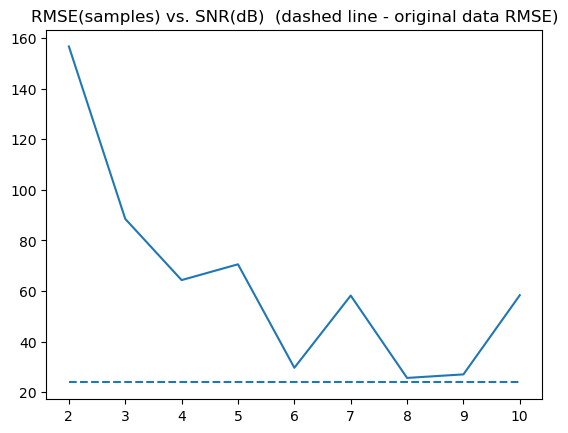

In [26]:
plt.title('RMSE(samples) vs. SNR(dB)  (dashed line - original data RMSE)')
plt.plot(range(2,11),  noisy_datasets_metric_result);
plt.hlines(y=original_dataset_metric_result, xmin=2, xmax=10, linestyles='dashed');

### Large Errors

Evaluate both the original traces and the synthetic noisy traces and save the large error traces - the traces where the model had picking error (residual) larger than  predefined threshold (1 second by default - 100 samples)

In [21]:
large_error_traces_index_list_original_dataset = find_large_error_traces(dataset=original_dataset, model=pretrained_model.float(), labels=original_labels, threshold_samples=LARGE_ERROR_THRESHOLD_SAMPLES, eval_fn=eval_batch_tuple_return)


large_error_traces_index_list_synthetic_noisy_datasets = [find_large_error_traces(dataset=synthetic_noisy_dataset, model=pretrained_model.float(), labels=synthetic_noisy_labels, threshold_samples=LARGE_ERROR_THRESHOLD_SAMPLES, eval_fn=eval_batch_tuple_return) for (synthetic_noisy_dataset, synthetic_noisy_labels) in zip(noisy_traces_list, noisy_traces_labels_list)]

100%|██████████| 1118/1118 [00:02<00:00, 412.99it/s]


In [22]:
dataset_lens = [int(len(large_error_traces_index_list_synthetic_noisy_dataset)) for large_error_traces_index_list_synthetic_noisy_dataset in large_error_traces_index_list_synthetic_noisy_datasets]

print(f'There are {dataset_lens} large errors in the noisy datasets')

dataset_len_original = int(len(large_error_traces_index_list_original_dataset))

print(f'There are {dataset_len_original} large errors in the original dataset')

There are [50, 34, 27, 25, 20, 23, 19, 15, 14] large errors in the noisy datasets
There are 10 large errors in the original dataset


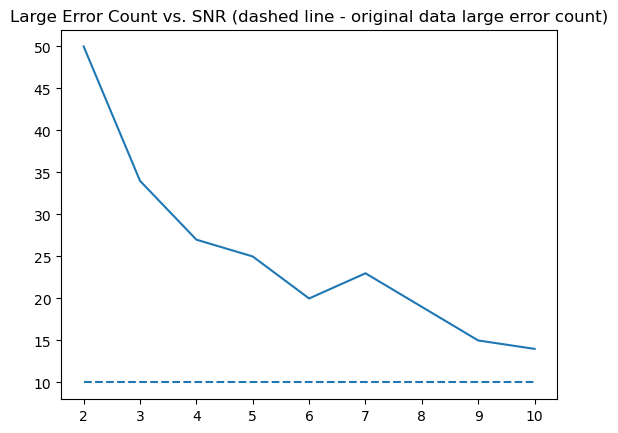

In [27]:
plt.title('Large Error Count vs. SNR (dashed line - original data large error count)')
plt.plot(range(2,11),  dataset_lens);
plt.hlines(y=dataset_len_original, xmin=2, xmax=10, linestyles='dashed');

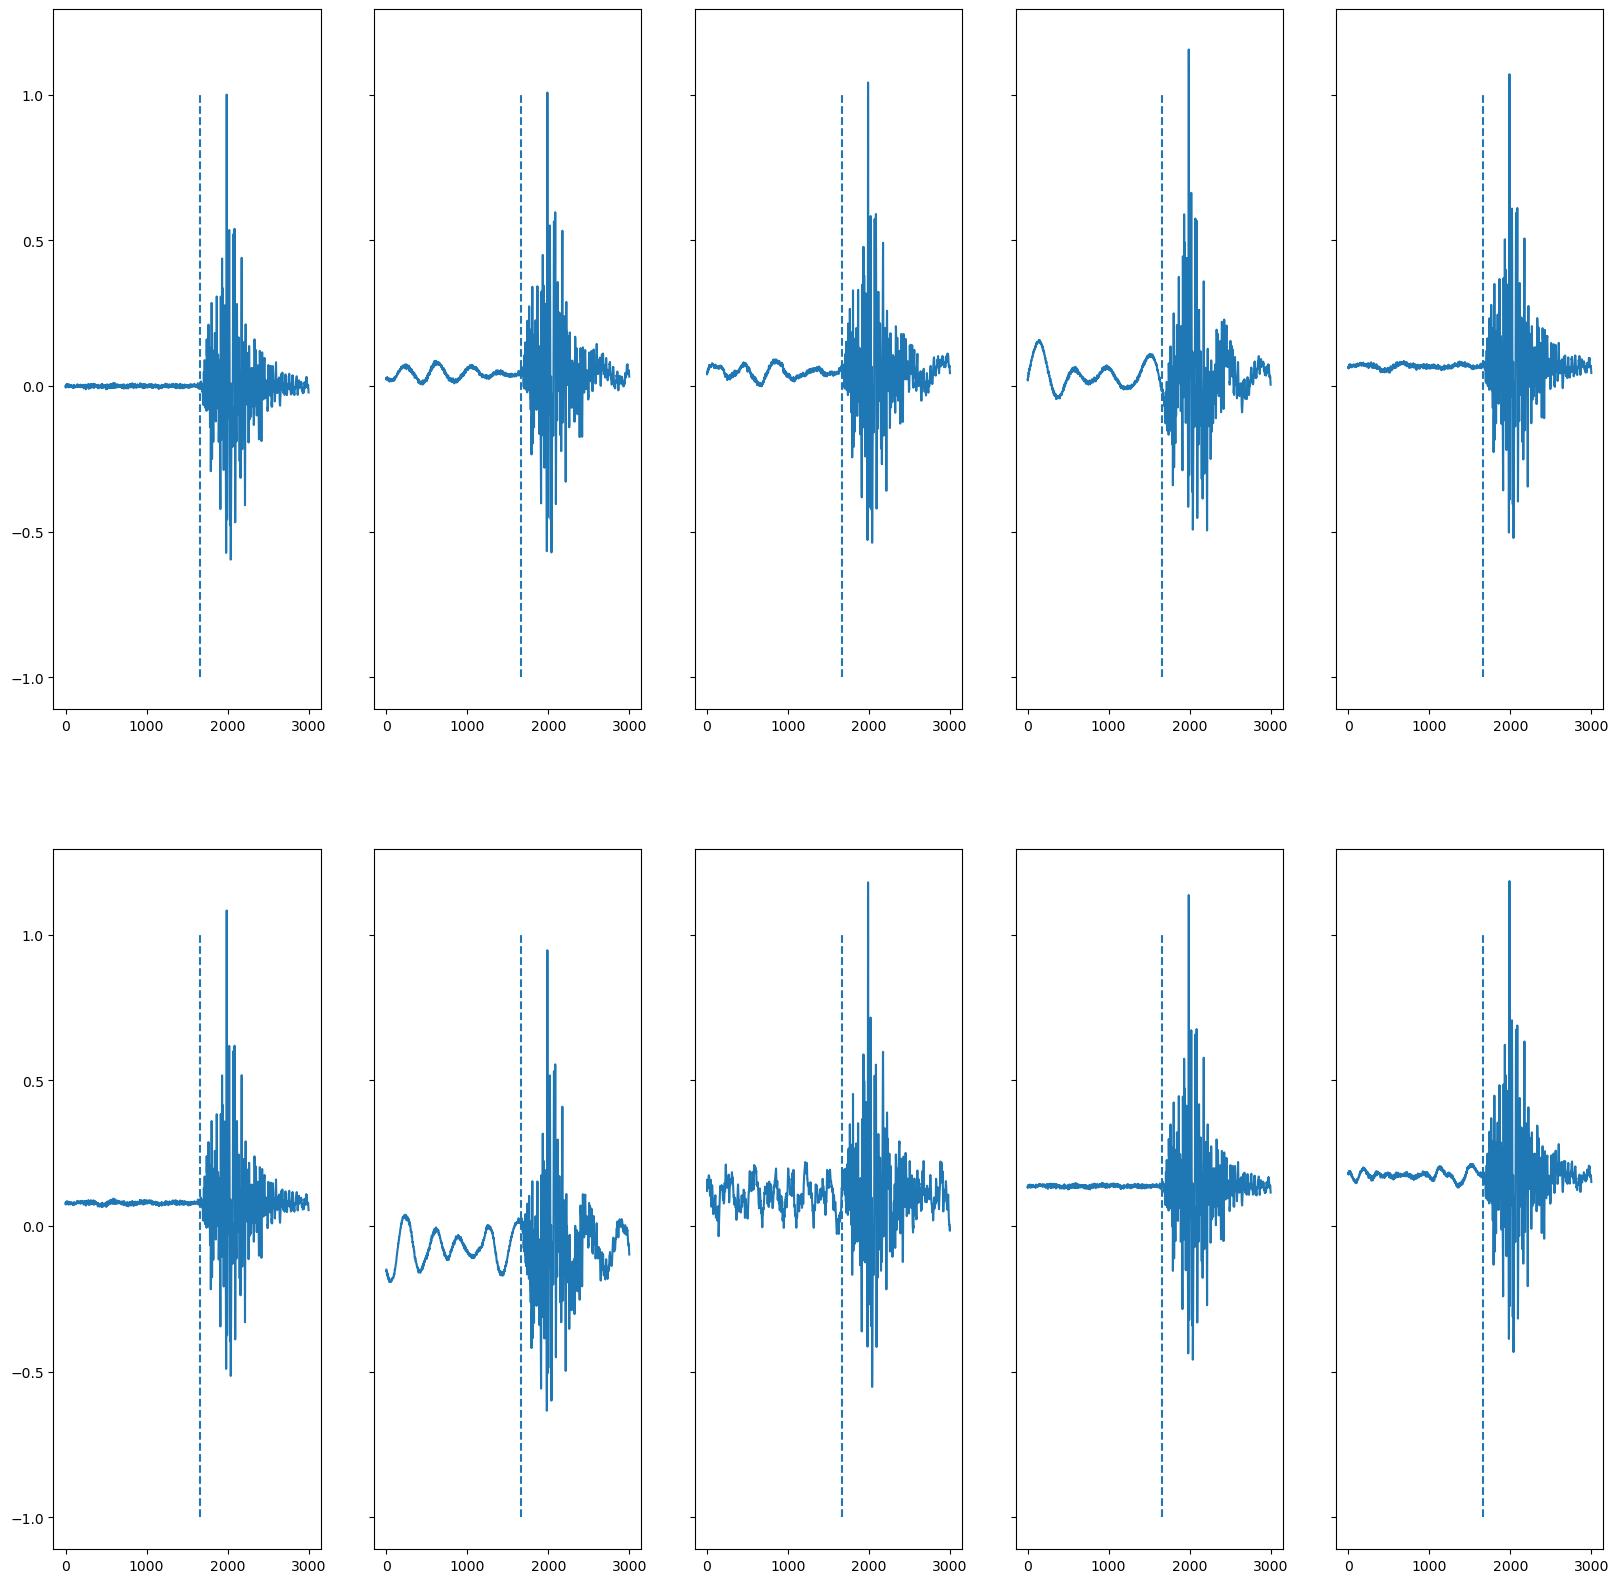

In [32]:
# idx = 5
#
# noised_traces =[synthetic_noisy_dataset[idx] for synthetic_noisy_dataset in noisy_traces_list]
# noised_labels =[synthetic_noisy_labels[idx] for synthetic_noisy_labels in noisy_traces_list]
#
# fig, axs = plt.subplots(2,5,figsize=(20,20), sharey='all')
# for i in [0,1]:
#     for j in [0,1,2,3,4]:
#         axs[i,j].plot(noised_traces[9 - j - i*5][0] if (i,j) != (0,0) else original_dataset[idx,0])
#         axs[i,j].vlines(x=original_labels[idx], ymin=-1, ymax=1, linestyles='dashed')
# ax_orig.plot((trace - factor * noise)[0]);
# ax_orig.vlines(x=label, ymin=-1, ymax=1,  label='Onset', linestyles='dashed');
# ax_orig.set_title('Original Trace')
# ax_noise.plot(factor*noise[0]);
# ax_noise.set_title('Noise added')
# ax_noised.plot(trace[0]);
# ax_noised.set_title('Noised Trace')